## Single Shot Multibox Detector (SSD)

In [196]:
#Importando as bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
#%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w10 - Deep Learning\data"

In [197]:
MODEL_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w10 - Deep Learning\models"
modelFile = MODEL_PATH + "/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
configFile = MODEL_PATH + "/ssd_mobilenet_v2_coco_2018_03_29.pbtxt"
classFile = MODEL_PATH + "/coco_class_labels.txt"

In [198]:
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

In [199]:
with open(classFile) as fp:
    labels = fp.read().split("\n")

In [200]:
def object_detection(net, img):
    dim = 300
    mean = (127.5, 127.5, 127.5)

    blob = cv2.dnn.blobFromImage(img, 1.0/127.5, (dim, dim), mean, True)

    # Pass blob to the network
    net.setInput(blob)

    # Peform Prediction
    objects = net.forward()
    return objects

In [201]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_text(im, text, x, y):

    # Get text size
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]

    # Use text size to create a black rectangle
    cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle
    cv2.putText(im, text, (x, y-5 ), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)

def display_objects(im, objects, threshold = 0.25):

    rows = im.shape[0]; cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])

        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)

        # Check if the detection is of good quality
        if score > threshold:
            display_text(im, "{}".format(labels[classId]), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)

    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30,10)); plt.imshow(mp_img); plt.show();

In [202]:
im1 = cv2.imread(DATA_PATH + '/images/street.jpg')
im2 = cv2.imread(DATA_PATH + '/images/baseball.jpg')
im3 = cv2.imread(DATA_PATH + '/images/soccer.jpg')

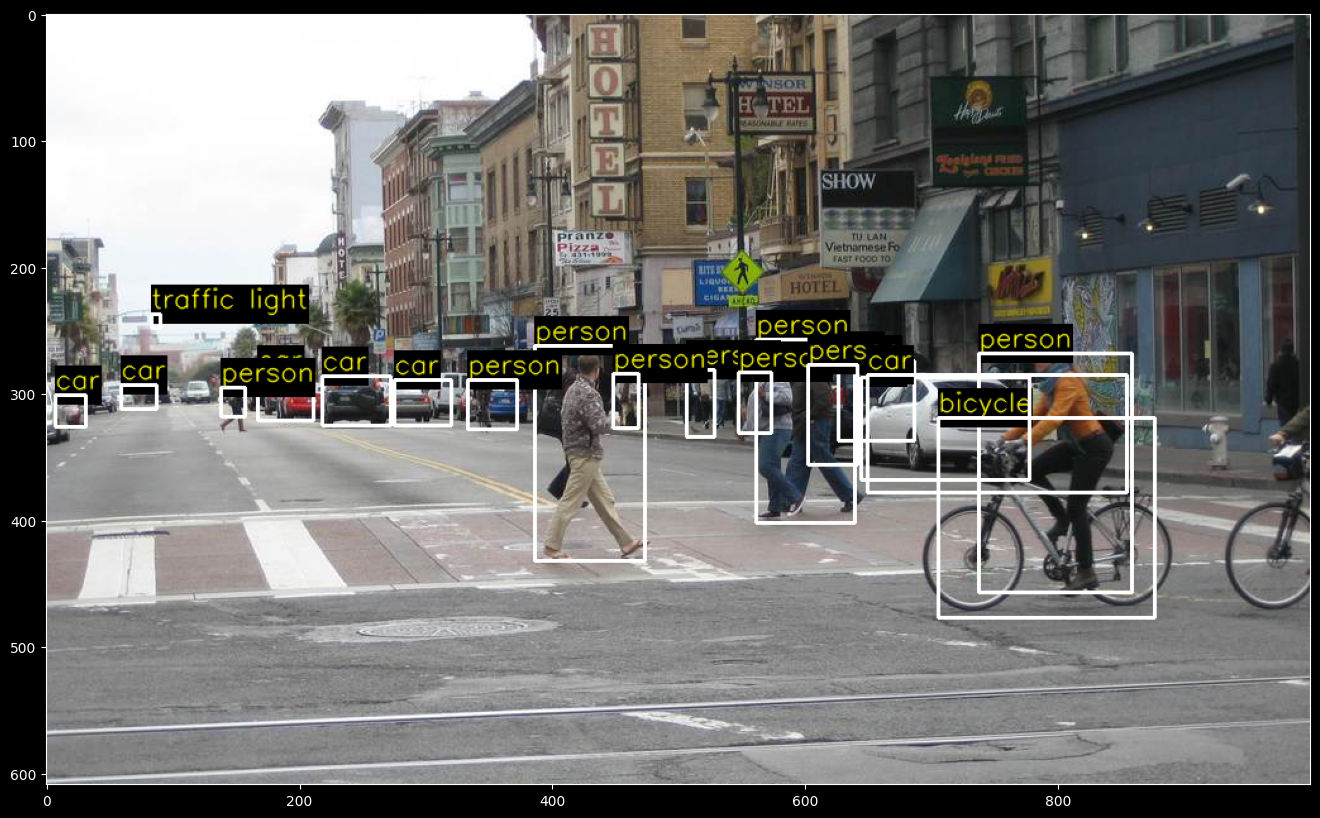

In [203]:
objects = object_detection(net, im1)
display_objects(im1, objects)

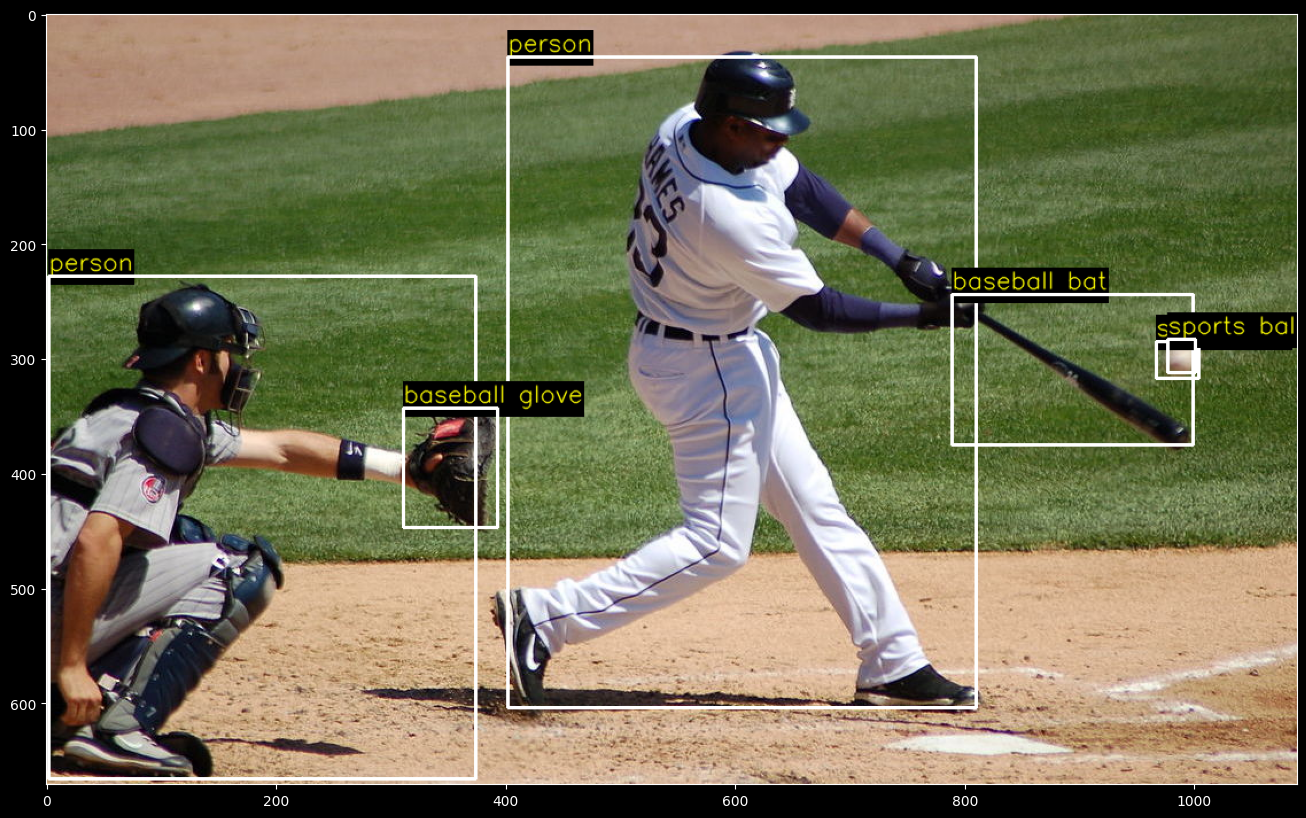

In [204]:
objects = object_detection(net, im2)
display_objects(im2, objects)

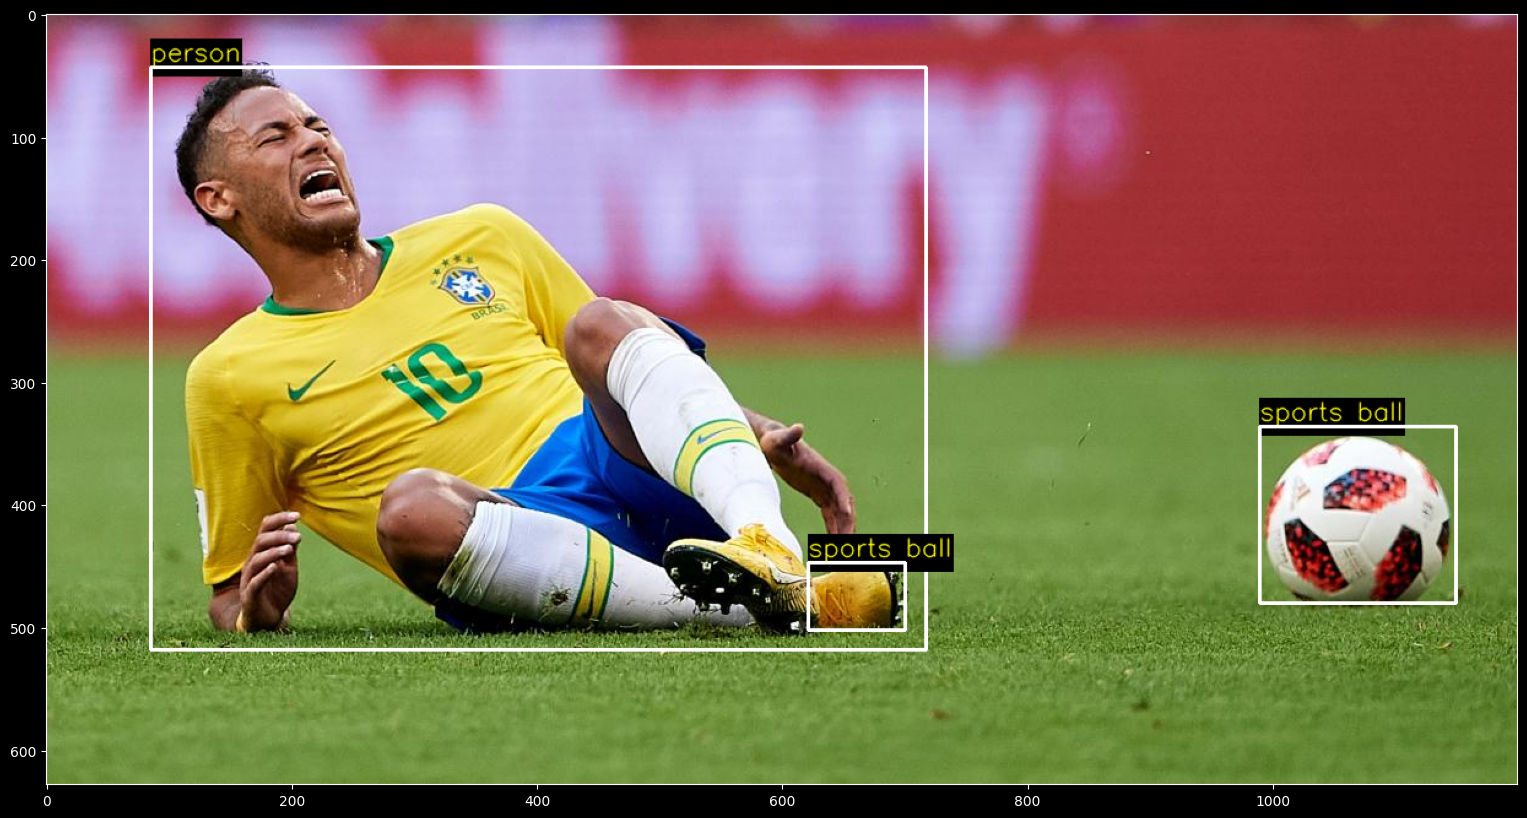

In [205]:
objects = object_detection(net, im3)
display_objects(im3, objects)

# You Look Only Once Detector ( YOLO v3 )

In [206]:
# Initialize the parameters
objectnessThreshold = 0.5 # Objectness threshold
confThreshold = 0.5       # Confidence threshold
nmsThreshold = 0.4        # Non-maximum suppression threshold
inpWidth = 416            # Width of network's input image
inpHeight = 416           # Height of network's input image

In [207]:
MODEL_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w10 - Deep Learning\models"

classesFile = MODEL_PATH + "\\coco.names"
modelConfiguration = MODEL_PATH + "\\yolov3.cfg"
modelWeights = MODEL_PATH + "\\yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

In [208]:
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [214]:
def getOutputsNames(net):
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    layerNames = net.getLayerNames()
    # Get the indices of the output layers, i.e. the layers with unconnected outputs
    outputLayersIndices = net.getUnconnectedOutLayers().flatten()
    outputLayers = [layerNames[i - 1] for i in outputLayersIndices]
    return outputLayers


In [215]:
def drawPred(classId, conf, left, top, right, bottom):
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

In [220]:
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold :
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold).flatten()
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)


In [221]:
# Process inputs
imagePath = DATA_PATH + "/images/bird.jpg"
frame = cv2.imread(imagePath)

In [222]:
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)
outs = net.forward(getOutputsNames(net))

In [223]:
# Remove the bounding boxes with low confidence
postprocess(frame, outs)

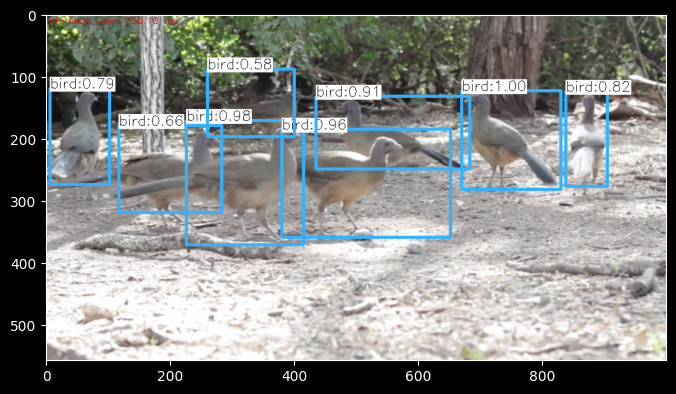

Inference time: 255.10 ms


In [225]:
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

plt.imshow(frame[...,::-1])
plt.show()
print(label)

https://www.learnopencv.com/deep-learning-based-object-detection-and-instance-segmentation-using-mask-rcnn-in-opencv-python-c/
https://www.youtube.com/watch?v=h56M5iUVgGs